### Test hirarchical clustering and consensus functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_fuzzy_data
from scipy.spatial import distance
from copy import deepcopy
from timeit import default_timer as timer
from datetime import timedelta
import importlib
%matplotlib inline

In [3]:
import clustertools.models.similarity as sim

In [4]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

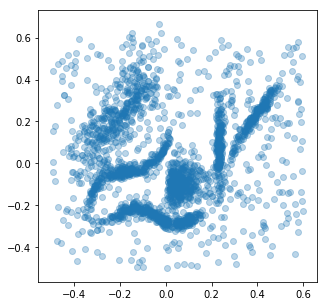

In [5]:
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1],alpha=.3)

In [6]:
fuzzy_copy = deepcopy(fuzzy)
np.random.shuffle(fuzzy)

Set some parameters

In [7]:
k = 10 # number of clusters to go down to
stop_dist = 0.3
num_stop_crit = 1
stride = 2
data = fuzzy[::stride]
n = len(data) # number of data points
print(n)
link = 'average'
#link = 'complete'
#link = 'single'
metric='euclidean'

1155


Fit hierarchical clustering object

In [8]:
hierarchical = sim.HierarchicalClustering(data, link=link, num_stop_crit=num_stop_crit, metric=metric, k=k, stop_dist=stop_dist)
hierarchical.fit()

Hierarchical clustering terminated.
Finished after 0:00:05.561100
Stopping cluster number was reached.
Current number of clusters: 10
Stopping distance was reached.
Current minimum cluster distance: 0.3


Plot results

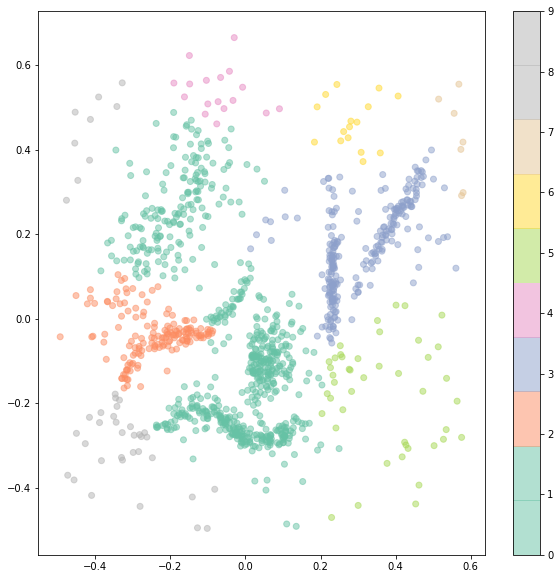

In [11]:
labels = hierarchical.cluster_labels
plt.figure(figsize=(10, 10))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

### Teste consensus einmal mit nur einem distance- und einer density-based clustering, und einmal mit zwei gleichen clusterings